In [1]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
import json
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import var_ex_X_task, get_model_params,gen_trials_from_model_dir,remove_spines #gen_trial_set
from tools_lnd import make_FP_axs,interp_h_tasks_w_context, get_filename, interp3d
from tools_lnd import gen_D_fp_qr
from sklearn.decomposition import PCA

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #fig save path
# ##################################################################
fig_name = 'suppfig10'
figpath = os.path.join(p_code,'figs',fig_name,fig_name+'HIJK')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
# ##################################################################
# #Find right model dir
# ##################################################################
data_fldr = 'suppfig10'
file = 'postrain_contextdelaydm2'
m = os.path.join(p_data,data_fldr,file)

(-0.1, 1.1)

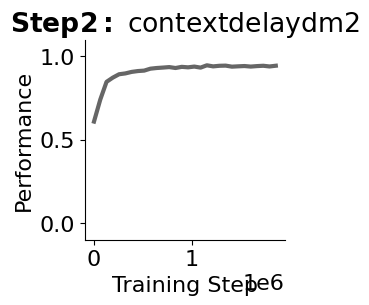

In [4]:
fig = plt.figure(figsize=(2, 2)) #7,2
plt.rcParams.update({'font.size': 16})
ax_post = fig.add_axes([0,0,1,1])
n_steps = 30

plt.sca(ax_post)
with open(os.path.join(m,'log.json'), 'r') as f:
    log_post = json.load(f)
rule = 'contextdelaydm2'
plt.plot(log_post['trials'][:n_steps],(log_post['perf_'+rule][:n_steps]),'-',c = 'k',
         alpha = .6,linewidth = 3,label = 'single task network')
ax_post.set_xlabel('Training Step')
ax_post.set_ylabel('Performance')
ax_post.set_title(r"$\bf{Step 2 :}$"+' contextdelaydm2')
ax_post.spines['top'].set_visible(False)
ax_post.spines['right'].set_visible(False)
plt.ylim([-.1,1.1])

#     figname = 'cost_transfer_pre_post'
#     plt.savefig(os.path.join(figpath,figname+ruleset+'.pdf'),bbox_inches = 'tight')

In [5]:
rule = 'contextdelaydm2'

In [6]:
def popvec(y):
    """Population vector read out.

    Assuming the last dimension is the dimension to be collapsed

    Args:
        y: population output on a ring network. Numpy array (Batch, Units)

    Returns:
        Readout locations: Numpy array (Batch,)
    """

    loc = np.arctan2(y[:,0], y[:,1])
    return np.mod(loc, 2*np.pi) # check this? January 22 2019

In [7]:
from tools_lnd import same_stim_trial
rule1 = 'contextdelaydm1'
rule2 = 'contextdelaydm2'
rule_set = [8,9]

mode='random'
noise_on = False
batch_size = 1000
n_rep = 20
perf_diff = np.zeros(n_rep)
perf_same = np.zeros(n_rep)

model = Model(m)
with tf.Session() as sess:
    model.restore()
    # model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    hparams = model.hp
    # create a trial
    
    for rep in range(n_rep):
        trial = generate_trials(rule1, hparams, mode=mode, noise_on=noise_on, batch_size =batch_size)
        trial2 = same_stim_trial(trial, rule_set[1])
        feed_dict = tools.gen_feed_dict(model, trial2, hparams)
        y_hat_test, c_lsq = sess.run([model.y_hat, model.cost_lsq], feed_dict=feed_dict)
        perf_diff[rep] = np.mean(get_perf(y_hat_test, trial.y_loc))
        
    for rep in range(n_rep):
        trial = generate_trials(rule2, hparams, mode=mode, noise_on=noise_on, batch_size =batch_size)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        y_hat_test, c_lsq = sess.run([model.y_hat, model.cost_lsq], feed_dict=feed_dict)
        perf_same[rep] = np.mean(get_perf(y_hat_test, trial.y_loc))     
        

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instea

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/__autograph_generated_filednvvo4ir.py:45: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(xi) is 0, if_body, else_body, get_state, set_state, ('gate_input_sum',), 1)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.


2024-04-18 18:59:19.467405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig10/postrain_contextdelaydm2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig10/postrain_contextdelaydm2/model.ckpt


In [6]:
from tools_lnd import same_stim_trial
rule1 = 'contextdelaydm1'
rule2 = 'contextdelaydm2'
rule_set = [8,9]

mode='random'
noise_on = False
batch_size = 1000
n_rep = 20
perf_diff = np.zeros(n_rep)
perf_same = np.zeros(n_rep)

model = Model(m)
with tf.Session() as sess:
    model.restore()
    # model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    
    for rep in range(n_rep):
        trial = generate_trials(rule1, hparams, mode=mode, noise_on=noise_on, batch_size =batch_size)
        trial2 = same_stim_trial(trial, rule_set[1])
        feed_dict = tools.gen_feed_dict(model, trial2, hparams)
        y_hat_test, c_lsq = sess.run([model.y_hat, model.cost_lsq], feed_dict=feed_dict)
        perf_diff[rep] = np.mean(get_perf(y_hat_test, trial.y_loc))
        
    for rep in range(n_rep):
        trial = generate_trials(rule2, hparams, mode=mode, noise_on=noise_on, batch_size =batch_size)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        y_hat_test, c_lsq = sess.run([model.y_hat, model.cost_lsq], feed_dict=feed_dict)
        perf_same[rep] = np.mean(get_perf(y_hat_test, trial.y_loc))     
        

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt


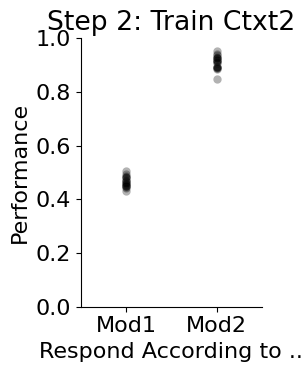

In [8]:
fig = plt.figure(figsize=(3,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)
plt.plot(np.zeros(n_rep)+1,perf_same,'ok',markeredgecolor = 'w',markeredgewidth = .1,alpha = .3,label = 'Respond Mod2')
plt.plot(np.zeros(n_rep),perf_diff,'ok',markeredgecolor = 'w',markeredgewidth = .1,alpha = .3,label = 'Respond Mod1')
plt.ylim(0,1)
plt.xlim(-.5,1.5)
plt.xticks([0,1])
ax.set_xticklabels(['Mod1','Mod2'])
plt.xlabel('Respond According to ..')
plt.ylabel('Performance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Step 2: Train Ctxt2')
plt.rcParams['axes.titlepad'] = 14
# fig.tight_layout()
plt.show()

In [9]:
y_loc = trial.y_loc
y_hat = y_hat_test


y_loc = y_loc[-1]
y_hat = y_hat[-1]

# Fixation and location of y_hat
y_hat_fix = y_hat[..., 0]
y_hat_loc = popvec(y_hat[..., 1:])

# Fixating? Correctly saccading?
fixating = y_hat_fix > 0.5

original_dist = y_loc - y_hat_loc
dist = np.minimum(abs(original_dist), 2*np.pi-abs(original_dist))
corr_loc = dist < 0.1*np.pi

# Should fixate?
should_fix = y_loc < 0

# performance
perf = should_fix * fixating + (1-should_fix) * corr_loc * (1-fixating)

In [10]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig10/postrain_contextdelaydm2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig10/postrain_contextdelaydm2/model.ckpt


In [11]:
[rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]

['contextdelaydm1', 'contextdelaydm2']

In [12]:
from tools_lnd import gen_trial_set,bifurc,plot_bifurc_ends, take_names, find_fp_dst_subspaces, gen_stim_trial_set
ruleset = 'mem_anti_motifs'
ax_labels = 'pca_h_cat'
fig_size = 6
cmap_discrete = ['w','k']
rule_set = [9,8]

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

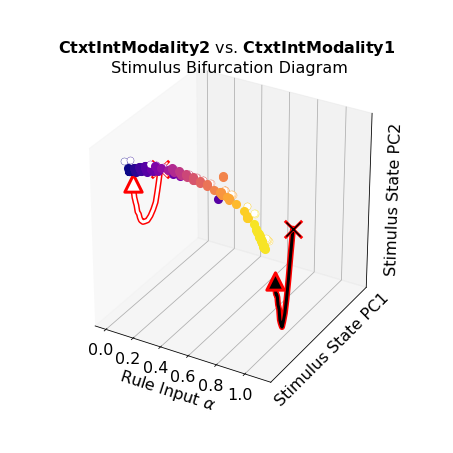

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

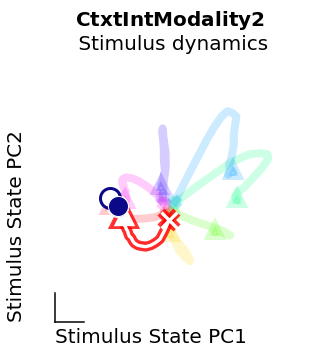

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parame

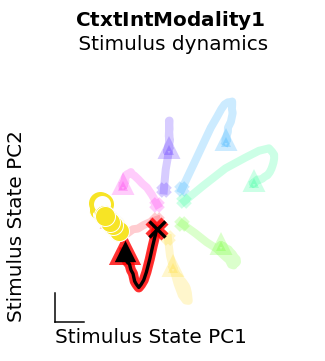

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

In [8]:
from tools_lnd import gen_trial_set,bifurc,plot_bifurc_ends, take_names, find_fp_dst_subspaces, gen_stim_trial_set
ruleset = 'mem_anti_motifs'
ax_labels = 'pca_h_cat'
fig_size = 6
cmap_discrete = ['w','k']
rule_set = [9,8]

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(rule_set[0])
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))


# rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
epoch_set = ['stim2','stim2']
t_set = [0,0]
rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')

D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')
# D_use = make_FP_axs(f, m, [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]], 
#                     epoch_set, axs = 'pca_h_cat', clust = 'False')
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = D_use[:,0]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}

# ax_labels[1] = r"$\bf{CtxtIntModality1}$"+' \n '+epoch_name_ax+' State PC1'
# ax_labels[2] = r"$\bf{CtxtIntModality1}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[1] = epoch_name_ax+' State PC1'
ax_labels[2] = epoch_name_ax+' State PC2'
ax_labels[0] = r"Rule Input $\alpha$"

interp = False
script_name = 'interp_tasks_small_init_stim_transfer'
tol_q = 1e-6

q_thresh = 4.5e-8

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
                   lims = [], view_ang = [30,-60])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
                 q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

trial_set = gen_stim_trial_set(m,rule_set)

# diff_rel_fp, diff_rel_fp_in, diff_rel_fp_out,f = find_fp_dst_subspaces(m, D_use,trial_set,
#                                                                      epoch_set,rule_set,t_set,
#                                                                      script_name = script_name,
#                                                                      figpath = figpath,
#                                                                      subselect_unstable = False, q_thresh = q_thresh)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

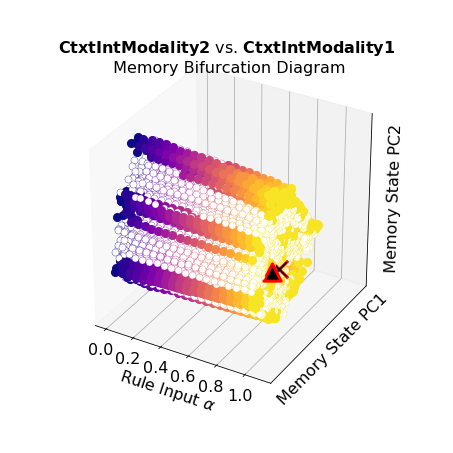

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

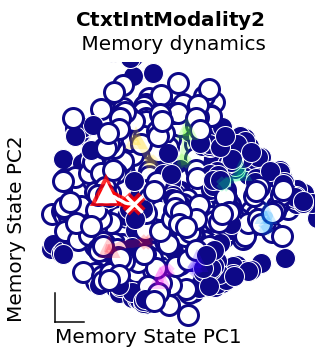

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parame

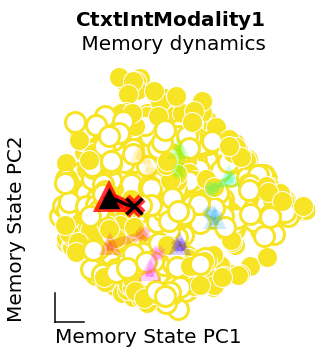

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

In [14]:
epoch_set = ['delay2','delay2']
t_set = [0,0]
rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')

# D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')

D_use = make_FP_axs(f, m, [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]], 
                    epoch_set, axs = 'pca_h_cat', clust = 'False')

w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = D_use[:,0]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
# ax_labels[1] = r"$\bf{CtxtDelayD1}$"+' \n '+epoch_name_ax+' State PC1'
# ax_labels[2] = r"$\bf{CtxtDelayD1}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[1] = epoch_name_ax+' State PC1'
ax_labels[2] = epoch_name_ax+' State PC2'
ax_labels[0] = r"Rule Input $\alpha$"

interp = False
script_name = 'interp_tasks_small_init_stim_transfer'
tol_q = 1e-6

q_thresh = 1e-5

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
                   lims = [], view_ang = [30,-60])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
                 q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

trial_set = gen_stim_trial_set(m,rule_set)

# diff_rel_fp, diff_rel_fp_in, diff_rel_fp_out,f = find_fp_dst_subspaces(m, D_use,trial_set,
#                                                                      epoch_set,rule_set,t_set,
#                                                                      script_name = script_name,
#                                                                      figpath = figpath,
#                                                                      subselect_unstable = False, q_thresh = q_thresh)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/interp_tasks_small_init_stim_transfer/contextdelaydm2_contextdelaydm1/tol_q_e_6.0/contextdelaydm2_contextdelaydm1_go1_go1_x180.0_x180.0_step_0.npz'

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


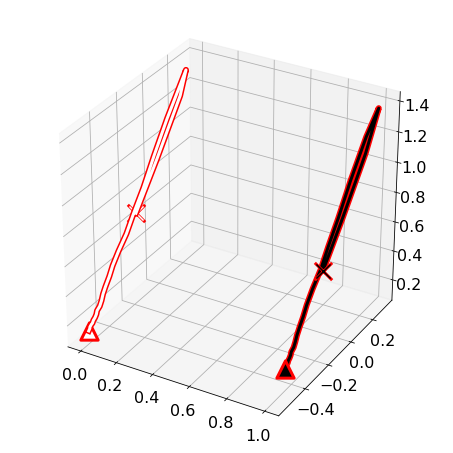

In [12]:
epoch_set = ['go1','go1']
t_set = [0,0]
rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')

# D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')

D_use = make_FP_axs(f, m, [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]], 
                    epoch_set, axs = 'pca_h_cat', clust = 'False')

w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = D_use[:,0]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
# ax_labels[1] = r"$\bf{CtxtDelayD1}$"+' \n '+epoch_name_ax+' State PC1'
# ax_labels[2] = r"$\bf{CtxtDelayD1}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[1] = epoch_name_ax+' State PC1'
ax_labels[2] = epoch_name_ax+' State PC2'
ax_labels[0] = r"Rule Input $\alpha$"

interp = False
script_name = 'interp_tasks_small_init_stim_transfer'
tol_q = 1e-6

q_thresh = 1e-5

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
                   lims = [], view_ang = [30,-60])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
                 q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

trial_set = gen_stim_trial_set(m,rule_set)

# diff_rel_fp, diff_rel_fp_in, diff_rel_fp_out,f = find_fp_dst_subspaces(m, D_use,trial_set,
#                                                                      epoch_set,rule_set,t_set,
#                                                                      script_name = script_name,
#                                                                      figpath = figpath,
#                                                                      subselect_unstable = False, q_thresh = q_thresh)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/interp_tasks_small_init_stim_transfer/contextdelaydm2_contextdelaydm1/tol_q_e_6.0/contextdelaydm2_contextdelaydm1_go1_go1_x180.0_x180.0_step_0.npz'

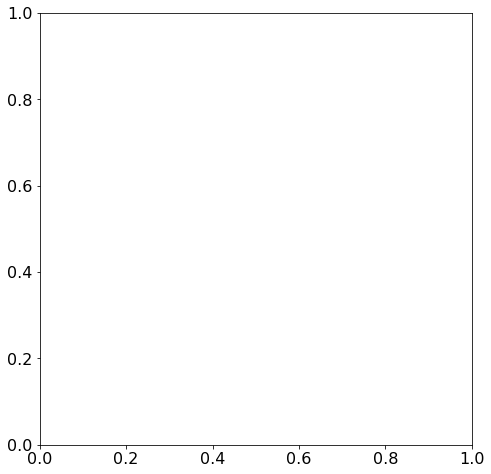

In [17]:
from tools_lnd import get_interp_filename, load_fps_from_interp
color_stim = True
cmap_grad = plt.get_cmap('plasma')
step_set = [0,19]

rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

if color_stim:
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, rule_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
else:
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
    trial2 = same_mov_inds(trial1, trial2) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))

filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
trial_set = [trial1, trial2]

trial_inds = range(0,np.shape(trial1.x)[1],int(np.shape(trial1.x)[1]/8))

for ri in [0,1]:
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    ax = fig.add_axes([0,0,1,1])

    sorted_fps, eig_decomps = load_fps_from_interp(m,script_name,rule_str,tol_q,filename_interp,
                                                     step_set[ri],q_thresh)

In [45]:
from tools_lnd import get_interp_filename
rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, rule_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring paramete

In [123]:
from tools_lnd import comp_eig_decomp

step_i = 0

fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                              filename_interp+'_step_'+str(step_i)+'.npz')
fp_struct = np.load(fp_dir)
fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
sorted_fps = fp_struct['xstar'][fp_inds,:]
eig_decomps = comp_eig_decomp(J_xstar)

In [124]:
max_eigenvals = np.empty((len(eig_decomps),3))
for x in range(len(eig_decomps)):
    max_eigenvals[x,:] = np.sort(eig_decomps[x]['evals'][:3])

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


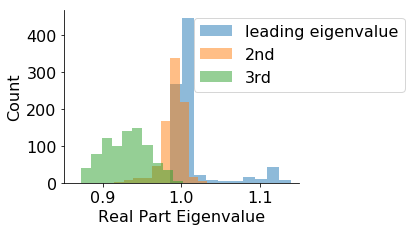

In [125]:
fig = plt.figure(figsize=(6,3.5),tight_layout=True,facecolor='white') 
ax = plt.subplot(111)
plt.hist(max_eigenvals[:,2],alpha = .5,label = 'leading eigenvalue')
plt.hist(max_eigenvals[:,1],alpha = .5,label = '2nd')
plt.hist(max_eigenvals[:,0],alpha = .5,label = '3rd')
plt.xlabel('Real Part Eigenvalue')
plt.ylabel('Count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(1, 1))
plt.xlim([0.85,1.15])

plt.savefig(os.path.join(figpath,'step_'+str(step_i)+'_eig_histogram.pdf'),bbox_inches='tight')
    
    
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final/LeakyRNN/softplus/diag/pro_small/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo/post_train_delayanti/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Docume

KeyboardInterrupt: 

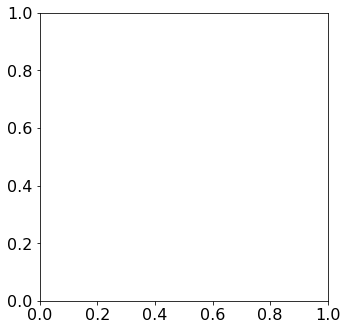

In [20]:
from tools_lnd import bifurc, plot_bifurc_ends, bifurc
fig_size = 6
ruleset = 'pro_small'
ax_labels = 'pca_h'
cmap_discrete = ['w','k']

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
seed = '1'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)

# rule_set = [2,5]
# rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
epoch_set = ['delay1','delay1']
t_set = [0,0]
rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = ax_labels, clust = 'False')
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
ax_labels[1] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1'
ax_labels[2] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[0] = r"Rule Input $\alpha$"


interp = False
script_name = 'interp_tasks_small_init_mov_transfer'
tol_q = 1e-6
q_thresh = 1e-5


# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                    lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
                 q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 2, threeD = True,cmap_discrete =  cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = .1, 
#            bifurc = False, plot_zero_plane = True)

rule_set = [2,5]
epoch_set = ['go1','go1']
t_set = [0,0]

# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                    lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
                 q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 2, threeD = True,cmap_discrete = cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = .1, 
#            bifurc = False, plot_zero_plane = True)

rule_set = [0,5]
trial_set = gen_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,['fix1','fix1'],t_set)
D_use[:,2] = D_fp_qr[:,0]

epoch_set = ['stim1','stim1']
t_set = [0,0]
script_name = 'interp_tasks_small_init_stim_transfer'

q_thresh = 1e-7

# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
#                    lims = [], view_ang = [31,-52])

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
#                  q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, ruleset = ruleset)

# script_name = 'interp_tasks_small_init_mov_transfer'

# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
#                    lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
                 q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 1, threeD = True,cmap_discrete = cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = .1, 
#            bifurc = False, plot_zero_plane = False)


In [8]:
lim_max = .000001
lim_min = .00000001

ylim_spread = lim_max-lim_min

while ylim_spread<1:
    lim_max = lim_max+1.5*ylim_spread
    lim_min = lim_min-1.5*ylim_spread
    ylim_spread = lim_max-lim_min

In [7]:
from tools_lnd import take_names, gen_trials_from_model_dir, gen_X_from_model_dir_epoch

def var_ex_X_task(ax, m, rule_set, epoch_set, n_components = 200, batch_size = 1000, plot_legend = False):

    rule_name_set = {}
    _, rule_name_set[0], _, _ = take_names(epoch_set[0],rule_set[0])
    _, rule_name_set[1], _, _ = take_names(epoch_set[1],rule_set[1])

    trial = gen_trials_from_model_dir(m,rule_set[0],mode='random',noise_on = False,batch_size = 200)
    X, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[0])
    pca = PCA(n_components = n_components)
    _ = pca.fit_transform(X.T)

    trial = gen_trials_from_model_dir(m,rule_set[1],mode='random',noise_on = False,batch_size = 200)
    X_ax, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[1])
    pca_ax = PCA(n_components = n_components)
    _ = pca_ax.fit_transform(X_ax.T)

    var_same = np.var(np.dot(pca.components_,X),axis = 1)
    var_ax = np.var(np.dot(pca_ax.components_,X),axis = 1)

    plt.rcParams.update({'font.size': 16})
    plt.plot(np.cumsum(var_same)/np.sum(var_same),'-ok',linewidth = 3,markersize = 10,alpha = .5,
             label = rule_name_set[0] + ' PCs')
    plt.plot(np.cumsum(var_ax)/np.sum(var_same),'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
             alpha = .5,label = rule_name_set[1] + ' PCs')
    plt.xlabel('N PCs',fontsize = 18)
    ax.xaxis.set_label_coords(.15, -0.025)
    plt.ylabel(rule_name_set[0] +'\n Variance Explained',fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([n_components,])
    ax.set_ylim([0,1.1])
    ax.set_xlim([-.05*n_components,2.5*n_components])
    if plot_legend==True:
        plt.legend(loc='upper center', bbox_to_anchor=(0.01, 1.3))

In [12]:
data_folder

'data/rnn/multitask/transfer_learn/final/'

stim1
stim1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdelaydm2:0' shape=(1, 128) dtype=float32_ref>
INFO:tensorflow:Restor

ValueError: No hp found for model_dir /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/2

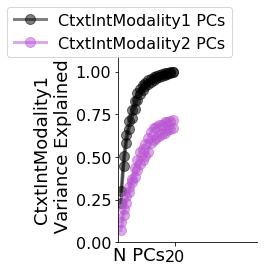

In [19]:
ruleset = 'leave_one'
post_train = 'contextdelaydm2'
data_folder = 'data/rnn/multitask/transfer_learn/final1/'
n_rnn = str(128)
lr = -6

task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
            'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
task_set.pop(9)

rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(5):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
        
    ri_set = [8,9]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['stim1','stim1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
        
    var_ex_X_task(ax, m, rule_set, epoch_set, n_components = 20, plot_legend = plot_legend)

figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(5):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
      
    ri_set = [8,9]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['delay1','delay1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
    
    var_ex_X_task(ax, m, rule_set, epoch_set, n_components = 20, plot_legend = plot_legend)
    
figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(5):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
      
    ri_set = [8,9]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['go1','go1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
    
    var_ex_X_task(ax, m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)
    
figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.show()

In [11]:
'/Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt'

'/Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/final1/LeakyRNN/softplus/diag/leave_one/14_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/post_train_contextdelaydm2/0/model.ckpt'

TypeError: var_ex_X_task() takes at least 4 arguments (5 given)

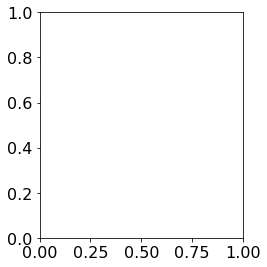

In [12]:
ruleset = 'pro_small'

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(4):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
        
    ri_set = [5,0]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['stim1','stim1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
        
    var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)

figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(4):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
      
    ri_set = [5,2]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['delay1','delay1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
    
    var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)
    
figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(1,1,1)
for seed_ind in range(4):
    seed=str(seed_ind)
    m = os.path.join(p,data_folder,rnn_type,activation,w_init,ruleset,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed)
      
    ri_set = [5,2]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    epoch_set = ['go1','go1']
    
    if seed=='0':
        plot_legend = True
    else:
        plot_legend = False
    
    var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)
    
figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

fig_fldr = os.path.join(figpath,'var',ruleset)
if not os.path.exists(fig_fldr):
    os.makedirs(fig_fldr)
        
plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
plt.show()